# CASSANDRA
The *Cassandra* dilemma occurs when valid warnings or concerns are dismissed or not believed. The term originates in Greek mythology. Cassandra was a daughter of Priam, the King of Troy. Struck by her beauty, Apollo provided her with the gift of prophecy, but when Cassandra refused Apollo's romantic advances, he placed a curse ensuring that nobody would believe her warnings. Cassandra was left with the knowledge of future events, but could neither alter these events nor convince others of the validity of her predictions.

---

## Problem Statement
Timing is absolutely key in financial markets. The ability to predict market peaks (both near-term and long-term) can help protect investors from significant drawdowns and elevated volatility. Of course, most of us do not have the luck of being endowed with such prophetic abilities. However, we may be able to leverage on the advances made in machine learning to create a more advanced barometer of risk (especially for US equity markets) to help investors navigate through the noise.

We define a *pullback* as whether the S&P 500 index will be lower in a month's time (i.e. rolling 4 weeks). The model we are looking to build should be able to do the following:
* Predict the likelihood that the S&P 500 index will fall over the coming month
* Explain which variables matter and how they interact

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno # Visualising our missing values
import pickle # For exporting our dataset

from pandas_profiling import ProfileReport # Automating the EDA process
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import timedelta

# Custom function(s)
import SIREN_func

In [2]:
# Ensuring our notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Customising aesthetics
sns.set_style('darkgrid')
sns.set_palette('icefire')

## Data collection
The bulk of our data has been sourced from Bloomberg via its API on excel. We will write a loop to pull every sheet and store in a dictionary for future use / manipulation. As with any model / algorithm, selecting which variables to include is one of the most important aspects of the workflow. I would like to think that my experience in financial markets should count for something here.

### Constructing our model
Fundamentals are definitely a key driver of equity market returns, especially over longer-term horizons, but near-term changes in flows, technicals, as well as sentiment also have an important role to play in near-term price action. With investors fluctuating between *Greed* and *Fear*, this often causes equity markets to overshoot. The data we've pulled can be broadly classified into the following categories:

* Macro barometers
    * Citi economic surprise indices
    * USD indices
    * US economic policy uncertainty index
    * Chicago Fed financial conditions index
* Fundamental indicators
    * Earnings revision ratios
    * 12-month forward P/E ratios
    * 12-month forward P/B ratios
* Sentiment indicators
    * Index performance (target variable)
    * VIX index
    * MOVE index
    * SKEW index
    * Put/call ratios (aggregated)
    * AAII sentiment (bull, bears)
    * CFTC net non-commercial longs for S&P 500 futures
* Technical indicators
    * Death cross (50 / 200dma regimes)
    * Percentage (%) of S&P 500 stocks at 52-week high)
* Rates
    * US 3-month, 2-year, 5-year, 10-year and 30-year treasury bond yields
    * US 10-year Treasury inflation-protected securities (TIPS)
    * Fed funds rate (Proxy for Fed rate hiking regimes)

### Importing dataset(s)
* `spx_fundamentals.xlsx`
* `spx_eri.xlsx`

In [29]:
# Read .xlsx highlighting S&P 500's earnings revisions
eri = pd.read_excel("../data/spx_eri.xlsx", sheet_name="Combined", parse_dates=['date'])

In [19]:
# Read each tab from our .xlsx file separately
xlsx = pd.ExcelFile('../data/spx_fundamentals.xlsx')

# Reading all sheets to a mapsheet_to_df_map = {}
empty_list = {}
for i in xlsx.sheet_names:
    empty_list[i] = pd.read_excel('../data/spx_fundamentals.xlsx', sheet_name=i, skiprows=11, parse_dates=['date'])

In [20]:
# Preview dictionary of dataframes
empty_list.keys()

dict_keys(['econ_sur', 'usd', 'epu', 'finc', 'pe', 'pb', 'eq_indices', 'como', 'credit', 'pct52w', 'vol', 'aaii', 'us_cftc', 'put_call', 'us_yields', 'eu_yields', 'eurdollar', 'fra_ois', 'fdtr', 'inflation'])

### Data dictionary
|Columns|Type|Dataset|Description|
|---|---|---|---|
|XX|XX|XX|XX|

## Visualising our features

**Citi Economic Surprise Indices**

These indices essentially measure whether data releases from an economy or group of companies have beaten or missed expectations (Actual - Consensus expectations, normalised by 10-year standard deviation). The neutral level is zero. Because of the rolling 3-month calculation window and typically low auto-correlation of surprises, the index tends to revert to zero (Extended positive or negative readings are an indication of bias in expectations). 

The index level tells us the number of standard deviations of surprises (in basis points) what the aggregate decay-adjusted surprise in the past 3 months has been. It has no natural bounds. Moves toward zero could be caused by new surprises or decay of past surprises.

Text(0.5, 0.98, 'Citi Economic Surprise Indices')

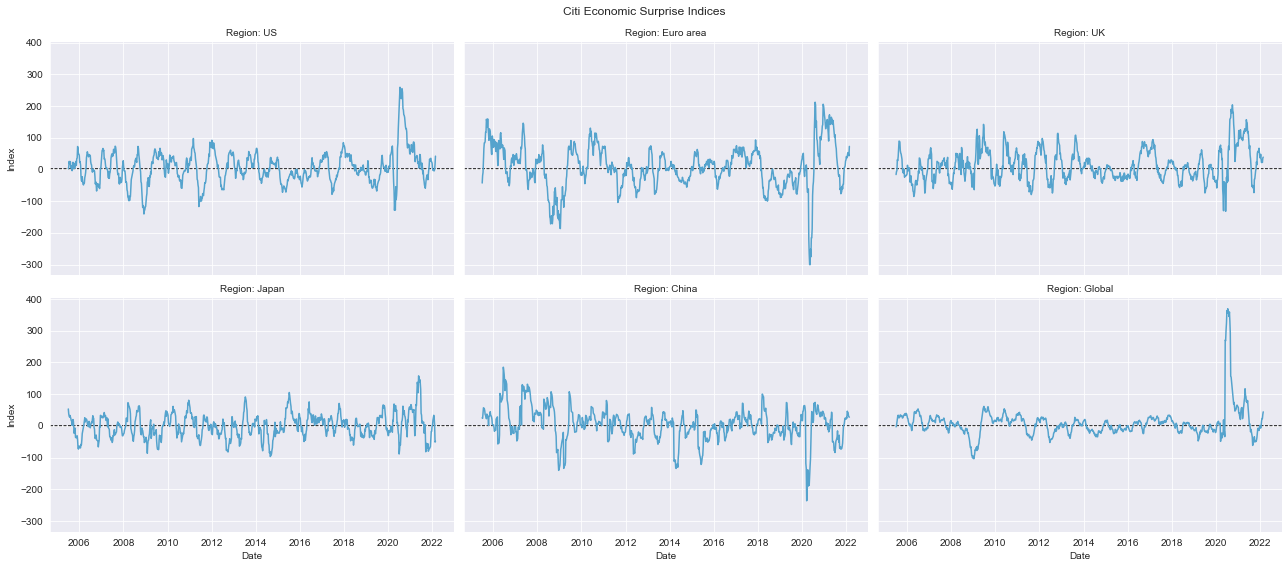

In [8]:
# Pre-processing for our charts
cesi_trends = empty_list['econ_sur'].melt(id_vars='date', var_name='type')
cesi_trends['type'] = cesi_trends['type'].map({'cesiusd':'US', 'cesieur':'Euro area', 'cesijpy':'Japan', 'cesigbp':'UK', 'cesicny':'China', 'cesiglf':'Global'})

# Charting
g= sns.relplot(data=cesi_trends, x='date', y='value', col='type', kind='line', col_wrap=3, aspect=1.5, height=4)
(g.map(plt.axhline, y=0, color="black", dashes=(2, 1), zorder=0).set_axis_labels("Date", "Index").set_titles("Region: {col_name}").tight_layout(w_pad=1))
g.fig.subplots_adjust(top=.92)
g.fig.suptitle('Citi Economic Surprise Indices')

**Price-earnings / Price-book ratios**

The **price-to-earnings ratio (P/E)** is the ratio for valuing a company that measures its current share price relative to its earnings per share (EPS). There are two types of EPS metrics: (1) the forward P/E, and the (2) trailing P/E. Our focus is on the forward (or leading) P/E, which uses future earnings guidance rather than trailing figures. This is useful for comparing current earnings to future earnings and helps provide a clearer picture of what earnings will look like - without changes and other accounting adjustments.

Similarly, the **price-to-book ratio (P/B)** is calculated by dividing the company's stock price by its book value per share (BVPS). An asset's book value is equal to its carrying value on the balance sheet. The P/B ratio reflects the value that market participants attach to a company's equity relative to the book value of its equity. The book value of equity is an accounting measure based on the historic cost principle and reflects past issuances of equity, augmented by any profits or losses, and reduced by dividends and share buybacks.



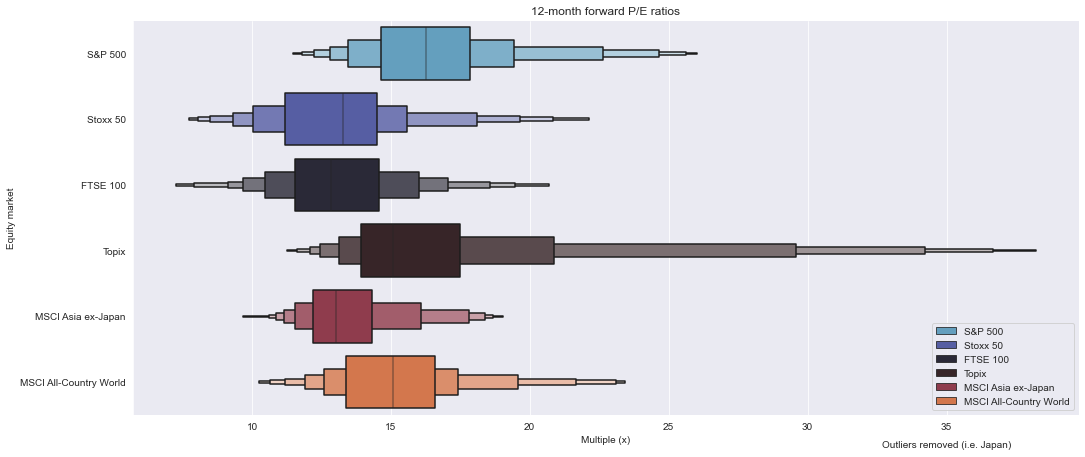

In [9]:
# Pre-processing for our charts
pe_trends = empty_list['pe'].melt(id_vars='date', var_name='type')

pe_trends['type'] = pe_trends['type'].map({'spx_pe':'S&P 500', 'sx5e_pe':'Stoxx 50', 'ftse100_pe':'FTSE 100', 'tpx_pe':'Topix', 'msci_axj_pe':'MSCI Asia ex-Japan', 'msci_acw_pe':'MSCI All-Country World'})

# Charting
sns.catplot(data=pe_trends, y='type', x='value', kind='boxen', hue='type', aspect=2.5, height=6, showfliers=False, legend=False, dodge=False)
plt.title("12-month forward P/E ratios")
plt.text(35, 6, "Outliers removed (i.e. Japan)", ha='center')
plt.xlabel("Multiple (x)")
plt.ylabel("Equity market")
plt.legend(loc="lower right")

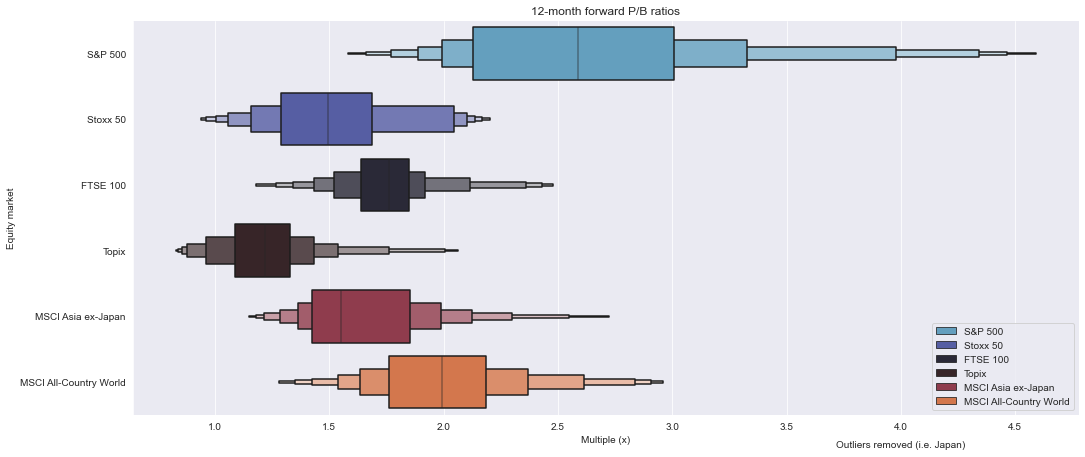

In [10]:
# Pre-processing for our charts
pb_trends = empty_list['pb'].melt(id_vars='date', var_name='type')

pb_trends['type'] = pb_trends['type'].map({'spx_pb':'S&P 500', 'sx5e_pb':'Stoxx 50', 'ftse100_pb':'FTSE 100', 'tpx_pb':'Topix', 'msci_axj_pb':'MSCI Asia ex-Japan', 'msci_acw_pb':'MSCI All-Country World'})

# Charting
sns.catplot(data=pb_trends, y='type', x='value', kind='boxen', hue='type', aspect=2.5, height=6, showfliers=False, legend=False, dodge=False)
plt.title("12-month forward P/B ratios")
plt.text(4, 6, "Outliers removed (i.e. Japan)", ha='center')
plt.xlabel("Multiple (x)")
plt.ylabel("Equity market")
plt.legend(loc="lower right")

### Volatility indices
The **VIX** index is a calculation designed to produce a measure of constant, 30-day expected volatility of the U.S. stock market, derived from real-time, mid-quote prices of S&P 500 Index call and put options. On a global basis, it is one of the most recognized measures of volatility - widely reported by financial media and closely followed by a variety of market participants as a daily market indicator.

The components of the VIX Index are near- and next-term put and call options with more than 23 days and less than 37 days to expiration. These include SPX options with “standard” 3rd Friday expiration dates and “weekly” SPX options that expire every Friday, except the 3rd Friday of each month. Once each week, the SPX options used to calculate the VIX Index “roll” to new contract maturities.

The **MOVE** index can be a useful tool to measure bond market sentiment and is a useful complement to the VIX index. It is a well-recognized measure of U.S. interest rate volatility that tracks the movement in U.S. Treasury yield volatility implied by current prices of *one-month* over-the-counter options on 2-year, 5-year, 10-year and 30-year Treasuries.

Deutsche Bank's currency volatility index (**CVIX**) provides a daily measure of volatility in G7 currencies. The index provides a benchmark for currency market participants. The index is designed to represent investors’ expectation of future volatility, and is calculated as the arithmetic average of the *3-month* level of implied volatility for all the major currency pairs (Based on 4pm London BBA fix). 

**Weights**: EURUSD (35.90%), USDJPY (21.79%), GBPUSD (17.95%), USDCHF (5.13%), USDCAD (5.13%), AUDUSD (6.41%), EURJPY (3.85%), EURGBP (2.56%), EURCHF (1.28%); Trade-weights correspond to the average daily turnover in each cross.

The CBOE **SKEW** index is a measure of the perceived tail risk in the S&P 500 based on deep out-of-the-money options - estimates the skewness of S&P 500 returns at the end of a *30-day* horizon. Consider the fact that most market participants are 'passive long', which means they are exposed to fluctuations in the market. Someone is more likely to express concerns following a 2% down day for the S&P 500 as opposed to a 2% up-day (This was usually a trigger to publish something!). So we can infer that there is a huge pool of natural buyers for S&P 500 downside protection (puts). Supply on the other hand, is still sizeable but narrower (i.e. selling OTM S&P 500 puts and purchase OTM calls). Simply put, there is a volatility skew, which describes the obervation that options with different strike prices, but the same underlying asset and expiration date can have different implied volatilities (Smiles vs. smirks).

When the S&P 500 falls, a few things typically occur in the index options marketplace. Typically, at-the-money (ATM) implied volatility levels increase, which usually sees the VIX move higher. To get a sense of what high or very high tail risk means, one can translate the value of SKEW to a risk-adjusted probability that the one-month S&P 500 log-return falls two or three standard deviations below the mean, and use VIX as an indicator of the magnitude of the standard deviation.

*Note*: S&P 500 skewness (S) is calculated from a portfolio of S&P 500 options that mimics an exposure to a skewness payoff. It tends to be negative and varies within a narrow range. It is transformed to SKEW by the following function: **SKEW = 100 - 10 x S**.

Text(0.5, 0.98, 'Volatility indices (Equities, Bonds, FX)')

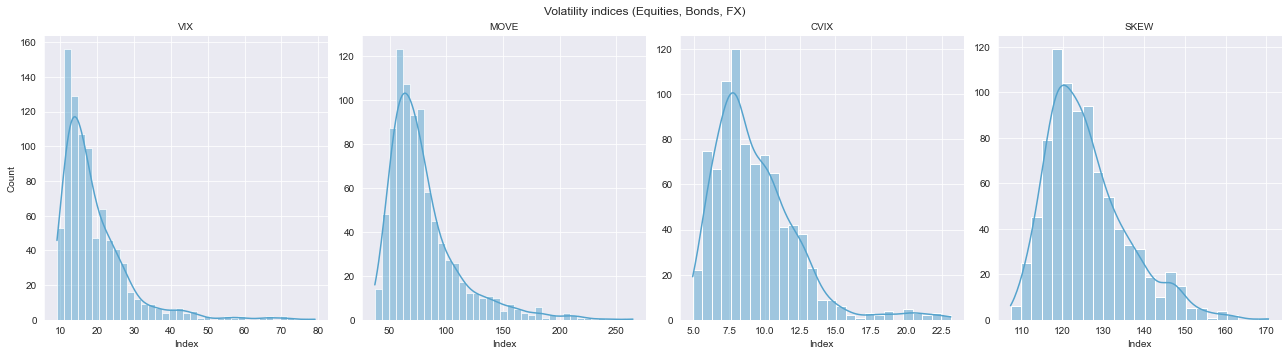

In [126]:
# Pre-processing for our charts
vol_trends = empty_list['vol'].melt(id_vars='date', var_name='type')

vol_trends['type'] = vol_trends['type'].map({'vix':'VIX', 'move':'MOVE', 'cvix':'CVIX', 'skew':'SKEW'})

# Charting
g = sns.FacetGrid(data=vol_trends, col='type', sharex=False, sharey=False, height=5, aspect=0.9)
g.map_dataframe(sns.histplot, x='value', kde=True).set_axis_labels("Index", "Count").set_titles("{col_name}").tight_layout(w_pad=1)
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Volatility indices (Equities, Bonds, FX)')

**Thoughts**: The distributions of these volatility indices are extremely right-skewed. We'll need to log-transform them.

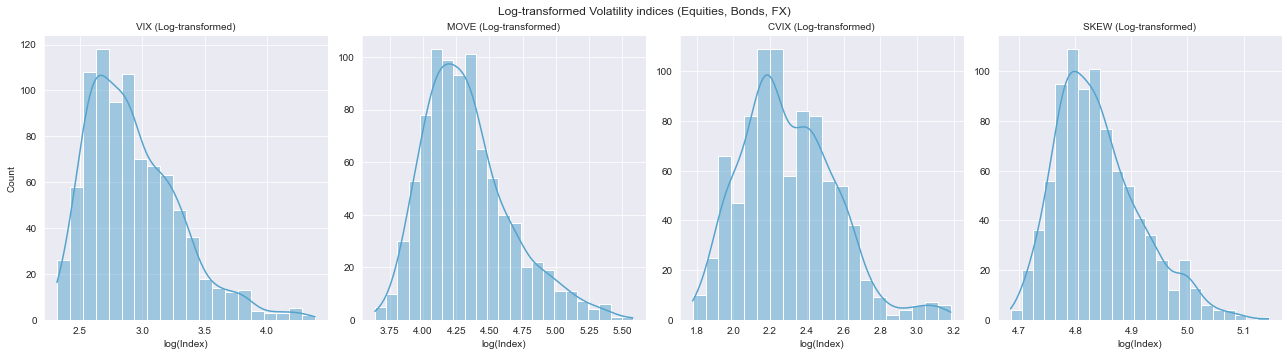

In [125]:
# Pre-processing for our charts
vol_trends_tidied = np.log1p(empty_list['vol'].set_index('date')).reset_index().melt(id_vars='date', var_name='type')

vol_trends_tidied['type'] = vol_trends_tidied['type'].map({'vix':'VIX', 'move':'MOVE', 'cvix':'CVIX', 'skew':'SKEW'})

# Charting
g = sns.FacetGrid(data=vol_trends_tidied, col='type', sharex=False, sharey=False, height=5, aspect=0.9)
g.map_dataframe(sns.histplot, x='value', kde=True).set_axis_labels("log(Index)", "Count").set_titles("{col_name} (Log-transformed)").tight_layout(w_pad=1)
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Log-transformed Volatility indices (Equities, Bonds, FX)')
plt.show()

### Earnings revision ratios
Defined as the rolling 3-month (13-week) ratio of analyst earnings upgrades over downgrades for FY1. A low and decreasing ERI should not bode well for S&P 500 returns in the near to medium-term.

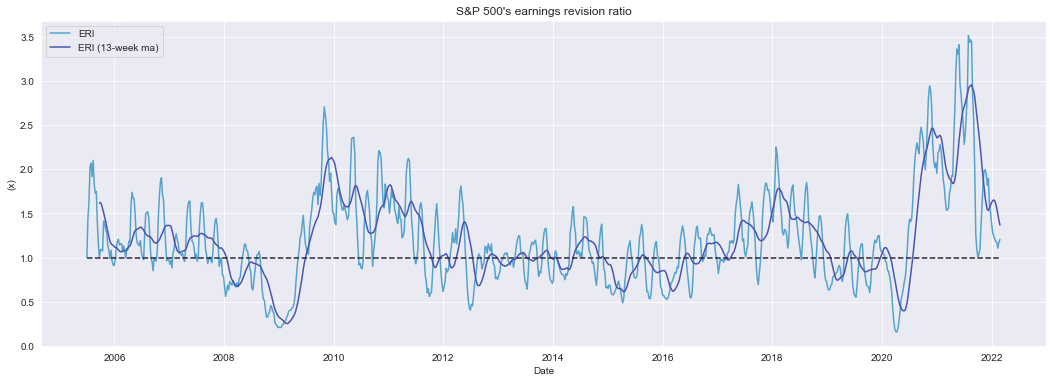

In [121]:
# Calculation of S&P 500's earnings revision ratio
eri['net'] = eri['upgrades']/eri['downgrades']
eri['eri'] = eri['net'].rolling(13).mean()

# Visualising our series
plt.figure(figsize=(18,6))
sns.lineplot(data=eri, x='date', y=eri['net'], label="ERI")
sns.lineplot(data=eri, x='date', y=eri['eri'], label="ERI (13-week ma)")
sns.lineplot(data=eri, x='date', y=1, linestyle="--")
plt.title("S&P 500's earnings revision ratio")
plt.xlabel("Date")
plt.ylabel("(x)")
plt.show()


## Exploring our data
With the help of a really handy package (i.e. pandas_profiling), we can carry out our extensive EDA with just a few lines of code. We could always write a loop for this process, but I figured it'll be better to examine each dataset individually to check the shape of the overall distribution, interactions / multi-collinearity between different variables.

**Pros**: Warnings provided (NaN values, variables with many zeros, categorical variables with high cardinality, etc)

**Cons**: Use with larger datasets; Quadratic increase in time as the size of the dataset rises

In [ ]:
# Exploring Citi Economic surprise indices
cesi_profile = ProfileReport(empty_list['econ_sur'].set_index('date'), title="Citi Economic Surprise Indices", explorative=True)
cesi_profile.to_widgets()

**Thoughts**: US economic surprises are highly correlated with Euro area, UK, China and global indices. We could technically leave Japan in, but we posit it will likely not have a significant impact on final model. We will probably create additional features here. We've done the same analysis for other datasets.

**Action plan**: Keep `cesiusd` and drop the rest. We will also only retain P/E ratios for S&P 500.

In [ ]:
# Exploring vol regimes
vol_profile = ProfileReport(empty_list['vol'].set_index('date'), title="vol", explorative=True)
vol_profile.to_widgets()

## Creation of custom functions
We will import our custom .py module (**SIREN_func**) which stores the following functions:
* `eda_clean`: Provides a quick snapshot of our project
* `derive_yield_curves`: Calculating 30y10ys, 30y5ys, 30y2ys, 30y3ms, 10y5ys, 10y2ys, 10y3ms, 5y2ys, 5y3ms, 2y3ms for US and Euro-area regions
* `fix_credit`: Standardising credit spreads as pp; Calculating spread between US high-yield and investment-grade bonds
* `fix_cftc`: Deriving CFTC net non-commercial positions as a % of total open interest
* `eri_diff`: Derive earnings revision indices and rolling changes across different horizons (4, 13-week)
* `roll_diff`: Calculate rolling differences for different time horizons (1, 4, 13, 26-week)
* `lag_roll_pct_chg`: Lagging rolling percentage changes for various equity indices (4-week)
* `roll_pct_chg`: Calculate rolling percentage changes for different time horizons (1, 4, 13, 26-week)
* `adjust_dates_only`: Standardise dates for merging dataframes later

We will once again rely on a combination of loops and custom functions to clean and tidy our dataset(s). We will also create some features for the following datasets:

* No engineering required (values-only; non-stationary)
* Rolling differences across different horizons (stationary)
    - Citi economic surprise indices (`econ_sur`)
    - US, Euro-area rates (`us_yields`, `eu_yields`)
        + Yield curves were also calculated
    - Credit spreads (`credit`)
* Rolling **percentage** changes across different horizons (stationary)
    - Equity indices (`eq_indices`)
    - USD indices (`usd`)
    - Commodities (`como`)
    - 12-month forward P/E ratios (`pe`)
    - 12-month forward P/B ratios (`pb`)

### Feature engineering
**Calculating differences across different horizons**

In [21]:
# Creating a empty dictionary to house our sub-dataset(s)
roll_d = {}

# Datasets of interest
for df in ['econ_sur', 'credit', 'us_yields', 'eu_yields', 'inflation']:
    if df in ['credit']:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(SIREN_func.fix_credit(empty_list[df]))
    
    elif df in ['us_yields', 'eu_yields']:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(SIREN_func.derive_yield_curves(empty_list[df]))

    else:
        roll_d[f'{df}_chg'] = SIREN_func.roll_diff(empty_list[df])

**Calculating percentage changes across different time horizons**

In [22]:
# Creating another empty dictionary to house sub-dataset(s)
roll_d2 = {}

# Datasets of interest
for df in ['usd', 'pe', 'pb', 'como', 'eq_indices']:
    if df in ['eq_indices']:
        roll_d2[f'{df}_4w_return'] = SIREN_func.lag_roll_pct_chg(empty_list[df], 4)
        
    else: 
        roll_d2[f'{df}_chg'] = SIREN_func.roll_pct_chg(empty_list[df]) # Tidy up with custom module later

**Storing the remaining time-series in a dictionary**

In [23]:
# Creating another empty dictionary to house sub-datasets
d3 = {}

# Datasets of interest
for df in ['epu', 'finc', 'pct52w', 'vol', 'aaii', 'us_cftc', 'put_call']:
    if df in ['us_cftc']:
        d3[df] = SIREN_func.fix_cftc(empty_list[df])
    
    # elif df in ['vol']:
    #     d3[df] = SIREN_func.log_transform_adjust_dates(empty_list[df])

    else: d3[df] = SIREN_func.adjust_dates_only(empty_list[df])


In [24]:
# Merging out dictionaries
final_dict = {**roll_d, **roll_d2, **d3}

In [25]:
# Printing out our keys to our sub-dataset(s)
final_dict.keys()

dict_keys(['econ_sur_chg', 'credit_chg', 'us_yields_chg', 'eu_yields_chg', 'inflation_chg', 'usd_chg', 'pe_chg', 'pb_chg', 'como_chg', 'eq_indices_4w_return', 'epu', 'finc', 'pct52w', 'vol', 'aaii', 'us_cftc', 'put_call'])

**Tidying earnings revision ratios**

In [30]:
# Pipe custom function to calculate ERIs and 4, 13-week differences
eri_chg = SIREN_func.eri_diff(eri, 4, 13)

In [31]:
# Combining all our datasets
full = eri_chg.copy()
for df in final_dict.keys():
    full = pd.merge(left=full, right=final_dict[df], how='left', on='date')

In [32]:
# Columns to drop
prefixes = [
    'cesieur_', 'cesigbp_', 'cesiglf_', 'cesicny_', 'cesijpy_',
    'sx5e_', 'ftse100_', 'msci_acw_', 'tpx_', 'msci_axj_', 'spx_pb',
    'vvix', 'eu_', 
    'bbdxy', 'dxy',
    'cftc_nc_long', 'cftc_oi', 'cftc_nc_short',
    'aaii_neut', 'us_baa_', 'em_usd_', 'global_hy_', 'asia_usd', 'us_hy_baa_spread',
    'bbg_us', 'bbg_uk', 'bbg_eu'
    # 'us_be10', 'us_5y5y'
    ]

unwanted = full.columns[full.columns.str.startswith(tuple(prefixes))]
unwanted

Index(['cesieur_1w_chg', 'cesigbp_1w_chg', 'cesijpy_1w_chg', 'cesicny_1w_chg',
       'cesiglf_1w_chg', 'cesieur_4w_chg', 'cesigbp_4w_chg', 'cesijpy_4w_chg',
       'cesicny_4w_chg', 'cesiglf_4w_chg',
       ...
       'sx5e_52w', 'ftse100_52w', 'tpx_52w', 'msci_axj_52w', 'msci_acw_52w',
       'vvix', 'aaii_neut', 'cftc_nc_long', 'cftc_nc_short', 'cftc_oi'],
      dtype='object', length=133)

In [33]:
# Dropping unwanted columns
full_tidied = full.drop(columns=unwanted)

In [34]:
# Previewing our final dataset
SIREN_func.eda_clean(full_tidied)

Dataset Statistics:
Shape of dataframe: (870, 121)
% of Null values in dataframe: 1.12%
% duplicate rows: 0.0%

Column names: Index(['eri', 'eri_1m_chg', 'eri_3m_chg', 'cesiusd_1w_chg', 'cesiusd_4w_chg',
       'cesiusd_13w_chg', 'cesiusd_26w_chg', 'us_hy_1w_chg', 'us_hy_4w_chg',
       'us_hy_13w_chg',
       ...
       'spx_52w', 'vix', 'move', 'cvix', 'skew', 'aaii_bull', 'aaii_bear',
       'cftc_nc_net', 'cftc_nc_net_pct_oi', 'cboe_us'],
      dtype='object', length=121)
Columns Count: 
float64    121
dtype: int64


In [35]:
# Let's drop all missing values
full_tidied.dropna(inplace=True)

In [36]:
# Let's save this down as a pickle file
full_tidied.to_pickle('../data/full.pkl')